# <span style='color:SteelBlue'>P6 - Segmentez des clients d'un site e-commerce</span>

**1- Missions**

Réaliser une première **étude de faisabilité** d'un moteur de **classification d'articles** basé sur une **image et une description** pour l'**automatisation** de l'attribution de la **catégorie de l'article**.

**2- Objectifs**

- analyser le jeu de données,
- réaliser :
    - un prétraitement des images,
    - un prétraitement des descriptions des produits
    - une réduction de dimension, 
    - puis un clustering. 

La représentation graphique aidera à convaincre que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.



#### I-Import de bibliothéques:

In [ ]:
import os 
from os import listdir
from glob import glob
from pathlib import Path
import PIL
from PIL import Image, ImageOps, ImageFilter
import cv2
import time
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn import cluster, metrics
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, MinMaxScaler
from sklearn.manifold import TSNE
from sklearn import preprocessing, decomposition
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model





#### Les fonctions:

In [2]:
def build_histogram(kmeans, des, image_num):

    " Cette fonction utilise le modèle de kmeans pour predire les" 
    "clusters auquel appartient a chaque descripteur"
    
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print(f"There is an issue with image {image_num}. The histogram contains no elements.")
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [3]:
def create_histogram_vectors(sift_keypoints, kmeans) :

    " Cette fonction permet de generer les histogrammes , prends liste de descripteur et le kmeans" 
    "pour chaque image , le but et de regroupper les descripteurs pour construire les histogramme"
    
    # Creation of a matrix of histograms
    hist_vectors=[]
    for image_num, image_desc in enumerate(sift_keypoints) :
        if image_num%100 == 0 : print(f"{str(image_num).zfill(4)} Images have been treated.")
        hist = build_histogram(kmeans, image_desc, image_num) #calculates the histogram
        hist_vectors.append(hist) #histogram is the feature vector
    print(f"{str(image_num+1).zfill(4)} Images have been treated in total. --- END.")
    return hist_vectors

In [4]:
def create_sift_keypoints(photo_list, use_canny=False, **kwags):

    "extraire les descripteurs sift pour les images"
   
    sift_keypoints = []
    sift = cv2.xfeatures2d.SIFT_create(**kwags,)

    for image_num, image_file in enumerate(photo_list) :
        if image_num%100 == 0 : print(f"{str(image_num).zfill(4)} Images have been treated.")
        image = cv2.imread(image_file, 0) # 0 = convert in gray (1 = color, -1 = unchanged)
        #image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        if use_canny :
            image=cv2.Canny(image, 60, 60)
        res = cv2.equalizeHist(image)   # equalize image histogram
        kp, des = sift.detectAndCompute(res, None)
        sift_keypoints.append(des)
    print(f"{str(image_num+1).zfill(4)} Images have been treated in total. --- END.")
    return sift_keypoints


In [5]:
type_donnée = 'image_sift'
def calcul_metriques_clusters(dataframe, type_donnee):

    " Calculate des métriques of clusters"
   
    valeur_reel = dataframe['CATEGORIE']
    valeur_pred = dataframe['Clusters']
    score_ari = adjusted_rand_score(valeur_reel, valeur_pred)

    metrique_clusters = pd.DataFrame({
        'Type_donnees': [type_donnee],
        'ARI': [score_ari]})
    return metrique_clusters

In [6]:
def affiche_repartition_par_clusters(clusters_labels):
    '''
    Affiche la répartition par cluster
    '''
    ax1 = plt.gca()
    my_series = pd.Series(clusters_labels).value_counts()
    data_vis = pd.DataFrame({'Clusters': my_series.index,'Nombre': my_series.values})
    data_vis = data_vis.sort_values(by='Clusters')
    # visualisation (barplot)
    sns.set_style('white')
    sns.barplot(x='Clusters', y='Nombre',data=data_vis, color='SteelBlue', ax=ax1)

    ax1.set_ylabel('Nombre)', fontsize=12)
    ax1.set_xlabel('Clusters', fontsize=12)
    ax1.set_title('Répartition par clusters', fontsize=14)
    plt.gcf().set_size_inches(6, 4)
    plt.grid(False)
    plt.show()

In [7]:
df = pd.read_csv('data_clean.csv')
data = df.copy()
my_df = data.drop(columns = ['Unnamed: 0'])


In [8]:
my_df.head(2)

,uniq_id,product_name,product_category_tree,image,description,brand,product_specifications,cat_depth,len_depth_,sub_cat 0,...,sub_cat 4,sub_cat 5,sub_cat 6,description_tokenize,product_name_tokenize,descr_token,description_lemma,product_name_lemmatisé,description_stemmer,product_name_lemma
0,55b85ea15a1536d46b7190ad6fff8ce7,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...","['Home Furnishing ', ' Curtains & Accessories ...",3,Home Furnishing,...,NaN,NaN,NaN,"['key', 'features', 'elegance', 'polyester', '...","['elegance', 'polyester', 'multicolor', 'abstr...",key features of elegance polyester multicolor ...,key elegance polyester multicolor abstract eye...,elegance polyester multicolor abstract eyelet ...,key eleg polyest multicolor abstract eyelet do...,elegance polyester multicolor abstract eyelet ...
1,7b72c92c2f6c40268628ec5f14c6d590,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...","['Baby Care ', ' Baby Bath & Skin ', ' Baby Ba...",4,Baby Care,...,"Sathiyas Cotton Bath Towel (3 Bath Towel, Red...",NaN,NaN,"['specifications', 'sathiyas', 'cotton', 'bath...","['sathiyas', 'cotton', 'bath', 'towel']",specifications of sathiyas cotton bath towel (...,specification cotton bath towel bath towel red...,sathiyas cotton bath towel,specif cotton bath towel bath towel red yellow...,cotton bath towel


In [9]:
my_df['image']

0       55b85ea15a1536d46b7190ad6fff8ce7.jpg
1       7b72c92c2f6c40268628ec5f14c6d590.jpg
2       64d5d4a258243731dc7bbb1eef49ad74.jpg
3       d4684dcdc759dd9cdf41504698d737d8.jpg
4       6325b6870c54cd47be6ebfbffa620ec7.jpg
                        ...                 
1045    958f54f4c46b53c8a0a9b8167d9140bc.jpg
1046    fd6cbcc22efb6b761bd564c28928483c.jpg
1047    5912e037d12774bb73a2048f35a00009.jpg
1048    c3edc504d1b4f0ba6224fa53a43a7ad6.jpg
1049    f2f027ad6a6df617c9f125173da71e44.jpg
Name: image, Length: 1050, dtype: object

* la colonne images contient des image avec l'extention.jpg

* Mettre les images dans une liste

In [10]:
list_image = [i for i in my_df['image']]
list_image

['55b85ea15a1536d46b7190ad6fff8ce7.jpg',
 '7b72c92c2f6c40268628ec5f14c6d590.jpg',
 '64d5d4a258243731dc7bbb1eef49ad74.jpg',
 'd4684dcdc759dd9cdf41504698d737d8.jpg',
 '6325b6870c54cd47be6ebfbffa620ec7.jpg',
 '893aa5ed55f7cff2eccea7758d7a86bd.jpg',
 'f355cc1ccb08bd0d283ed979b7ee7515.jpg',
 'dd0e3470a7e6ed76fd69c2da27721041.jpg',
 '41384da51732c0b4df3de8f395714fbb.jpg',
 '710ed5f2393a4b9e8823aa0029f71f93.jpg',
 '920154acbe49d3202ed7d2ed2df1ea13.jpg',
 '08452abdadb3db1e686b94a9c52fc7b6.jpg',
 '1e8741b5ae27a513546c94b3f3312aee.jpg',
 '189fa66a5fa6f08d2802a62ecf0be298.jpg',
 'bbb8cdc5406ff60ff06ff64630f2ca47.jpg',
 '1120bc768623572513df956172ffefeb.jpg',
 '5479bb7028827d60000720a2c135976a.jpg',
 '733aa1e801a139fa8dc7be9f0eff5ee0.jpg',
 '62c35de4df27437d3597963fac55a8b6.jpg',
 '33d97d63c037078cd3f08033966d6a88.jpg',
 'd7ca2b06b4f4d3b98c61c377b18a2d6b.jpg',
 'f74476ba64365d97a5be7d375cbf4c7a.jpg',
 'fda50982a672ef8835de5c1cc86f8bfc.jpg',
 '4788f5466992da09024b8ffcc8a5cba4.jpg',
 '653826cd53f1d9

* Récupération de l'adresse dans le répertoire pour chaque image:

* On fait la concatination de l'adresse d'image et chaque image dans dataframe

In [11]:
#path = Path('../Flipkart/Images')
path = 'Images/'
image = [path + image for image in my_df['image']]
image

['Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg',
 'Images/7b72c92c2f6c40268628ec5f14c6d590.jpg',
 'Images/64d5d4a258243731dc7bbb1eef49ad74.jpg',
 'Images/d4684dcdc759dd9cdf41504698d737d8.jpg',
 'Images/6325b6870c54cd47be6ebfbffa620ec7.jpg',
 'Images/893aa5ed55f7cff2eccea7758d7a86bd.jpg',
 'Images/f355cc1ccb08bd0d283ed979b7ee7515.jpg',
 'Images/dd0e3470a7e6ed76fd69c2da27721041.jpg',
 'Images/41384da51732c0b4df3de8f395714fbb.jpg',
 'Images/710ed5f2393a4b9e8823aa0029f71f93.jpg',
 'Images/920154acbe49d3202ed7d2ed2df1ea13.jpg',
 'Images/08452abdadb3db1e686b94a9c52fc7b6.jpg',
 'Images/1e8741b5ae27a513546c94b3f3312aee.jpg',
 'Images/189fa66a5fa6f08d2802a62ecf0be298.jpg',
 'Images/bbb8cdc5406ff60ff06ff64630f2ca47.jpg',
 'Images/1120bc768623572513df956172ffefeb.jpg',
 'Images/5479bb7028827d60000720a2c135976a.jpg',
 'Images/733aa1e801a139fa8dc7be9f0eff5ee0.jpg',
 'Images/62c35de4df27437d3597963fac55a8b6.jpg',
 'Images/33d97d63c037078cd3f08033966d6a88.jpg',
 'Images/d7ca2b06b4f4d3b98c61c377b18a2d6

* Ajouter la colonne image_path dans my_df:

In [12]:
my_df['image_path'] = image

* Pour notre analyse en s'interesse à image et image_path et la premiere catégories

In [13]:
df_image = my_df[['image','image_path','sub_cat 0']]

#### Analyse exploratoire:

In [14]:
df_image['sub_cat 0'].value_counts()

sub_cat 0
Home Furnishing                150
Baby Care                      150
Watches                        150
Home Decor & Festive Needs     150
Kitchen & Dining               150
Beauty and Personal Care       150
Computers                      150
Name: count, dtype: int64

* comme image et comme texte en trouve 150 image dans chaque catégories

In [15]:
#image_counts = df_image.groupby('sub_cat 0').apply(lambda x: x['image'].count())
image_counts = df_image.groupby('sub_cat 0')['image'].count()
image_counts.to_frame()


,image
sub_cat 0,
Baby Care,150
Beauty and Personal Care,150
Computers,150
Home Decor & Festive Needs,150
Home Furnishing,150
Kitchen & Dining,150
Watches,150


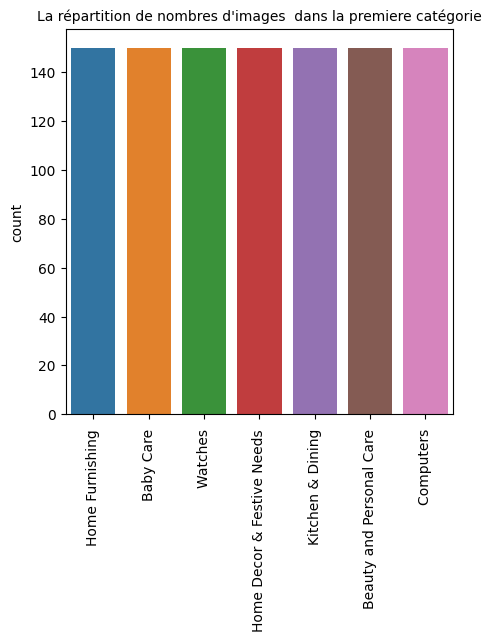

In [52]:
def destribution_categories(data, column, figsize ):
    y= data[column].value_counts()
    x = data[column].unique()
    plt.figure(figsize = figsize)
    sns.barplot(data = df, x = x, y = y)
    plt.title(f"La répartition de nombres d'images  dans la premiere catégorie", fontsize = 10)
    plt.xticks(rotation = 90)
    plt.show()
destribution_categories(df_image, 'sub_cat 0', figsize =(5,5))

* Visualisation des images:

In [16]:
df_image['image_path'][0]

'Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg'

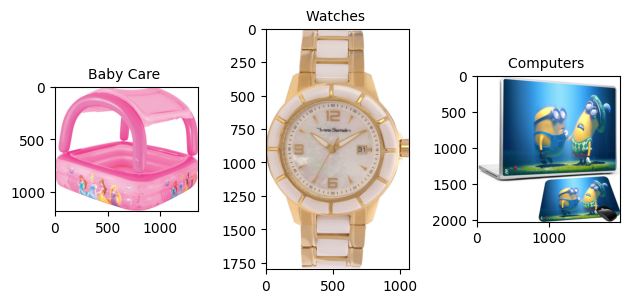

In [17]:
img_simples = df_image.sample(3).reset_index()
fig, axes = plt.subplots(1, 3)
for i, ax in enumerate(axes.flat):
    if i < 3:
        filename = np.array(Image.open(img_simples['image_path'][i]))
        ax.imshow(filename)
        ax.set_title(img_simples['sub_cat 0'][i],fontsize = 10)
plt.tight_layout()
plt.show()


* D'aprés la visualisation on va que les images n'ont pas la meme dimenssion,
 ce qui necessite le prétraitement avant de faire la classification.

******
**********

##### Résumé pour SIFT:


* "SIFT" est l'acronyme de "Scale-Invariant Feature Transform". C'est un algorithme de détection de caractéristiques largement utilisé en vision par ordinateur pour extraire et décrire des points d'intérêt (keypoints) dans des images. Il a été proposé par David G. Lowe en 1999.
* L'algorithme SIFT se divise en plusieurs étapes :
    * Détection : création de l'espace des échelles, calcul des "DoG" (Différence of Gaussian), localisation des points d'intérêt.
    * Description : assignation d'orientation, création des descripteurs.


*******
******

### Exemple de traitement d'une image:

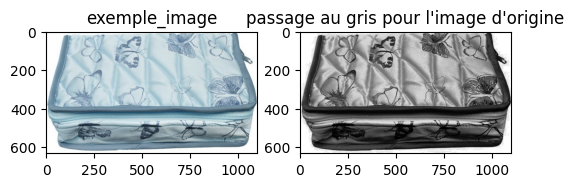

In [19]:
sift = cv2.xfeatures2d.SIFT_create()
exemple_image = cv2.imread(df_image['image_path'][100])
image_gris = cv2.imread(df_image['image_path'][100],0)
image_gris = cv2.equalizeHist(image_gris) 
plt.figure(figsize=(6, 5))
# original_image:
plt.subplot(1, 2, 1)
plt.title('exemple_image')
plt.imshow(exemple_image)

# Image avec les points clés:
plt.subplot(1, 2, 2)
plt.imshow(image_gris,cmap='gray')
plt.title("passage au gris pour l'image d'origine")
plt.show()


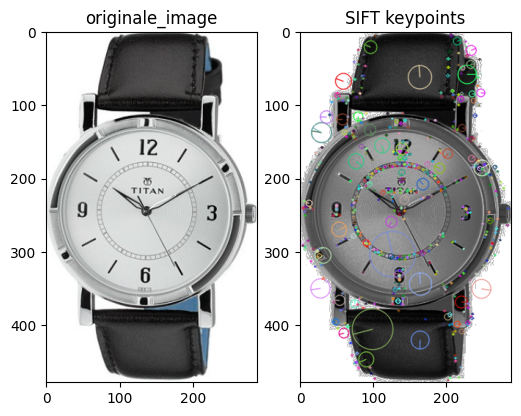

[[ 95.  46.  46. ...  12.   5.   3.]
 [  0.   0.   0. ...   0.   1.   1.]
 [ 65. 125.  52. ...   6.   4.   3.]
 ...
 [  1.  86.  76. ...   0.   0.   0.]
 [  1.  49. 111. ...   0.   0.  52.]
 [  0.  97.  91. ...   0.   0.   3.]]
(621, 128)


In [20]:
origi_image = cv2.imread(path+df_image['image'][13])
sift = cv2.xfeatures2d.SIFT_create()# classe de sift(pour detecter les point d'interet)
image = cv2.imread(path+df_image['image'][13],0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


plt.figure(figsize=(6, 5))
# original_image:
plt.subplot(1, 2, 1)
plt.title('originale_image')
plt.imshow(origi_image)

# Image avec les points clés:
plt.subplot(1, 2, 2)
plt.imshow(img)
plt.title('SIFT keypoints')
plt.show()
print(des)
print(des.shape)


#### Prétraitements des images via sift:
* Extraction de features image pvia sift
##### - Creations de descripteurs pour chaque images:

In [22]:
# je choisi le nombre de features = 1000
nfeatures = 1000
image_liste = df_image['image'].to_list()
len(image_liste)

1050

In [23]:
temps1 = time.time()
sift_keypoints_by_img = create_sift_keypoints(df_image['image_path'], nfeatures=nfeatures)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Number of SIFT descriptors : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("Run time for the SIFT descriptor : ", "%15.2f" % duration1, "secondes")


0000 Images have been treated.
0100 Images have been treated.
0200 Images have been treated.
0300 Images have been treated.
0400 Images have been treated.
0500 Images have been treated.
0600 Images have been treated.


***************
*****************
* Un nombre important de features est : 989655, ce qui dificile de les regroper par les méthode classique , silouhette et bouldin ,
* on utilise MiniBatchkmeans pour regrouper les données, et et réduit le temps de calcul.
*****************
*******************

#### Création des clusters de descripteurs
* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [62]:
# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0)) 
# le nombre de clusters est definis en fonction de la racine carrée de la taille 
# de l'ensemble de descripteurs SIFT (sift_keypoints_all) arrondie à l'entier le plus proche

print("Maximum Number of Clusters : ", k)
print(f"Creation of {k} SIFT-Descriptor Clusters ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("Run time for MiniBatchKMeans : ", "%15.2f" % duration1, "seconds")

Maximum Number of Clusters :  995
Creation of 995 SIFT-Descriptor Clusters ...


c:\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Run time for MiniBatchKMeans :            18.31 seconds


In [63]:
# Creation of histograms (features)
temps1 = time.time()
im_features = np.asarray(create_histogram_vectors(sift_keypoints_by_img, kmeans))
duration1 = time.time()-temps1
print("Total time to create Histograms : ", "%15.2f" % duration1, "secondes")

0000 Images have been treated.
0100 Images have been treated.
0200 Images have been treated.
0300 Images have been treated.
0400 Images have been treated.
0500 Images have been treated.
0600 Images have been treated.
0700 Images have been treated.
0800 Images have been treated.
0900 Images have been treated.
1000 Images have been treated.
1050 Images have been treated in total. --- END.
Total time to create Histograms :             4.08 secondes


(array([292., 515., 133.,  35.,  11.,   0.,   3.,   4.,   1.,   1.]),
 array([0.3495225 , 0.81648783, 1.28345316, 1.75041848, 2.21738381,
        2.68434914, 3.15131446, 3.61827979, 4.08524511, 4.55221044,
        5.01917577]),
 <BarContainer object of 10 artists>)

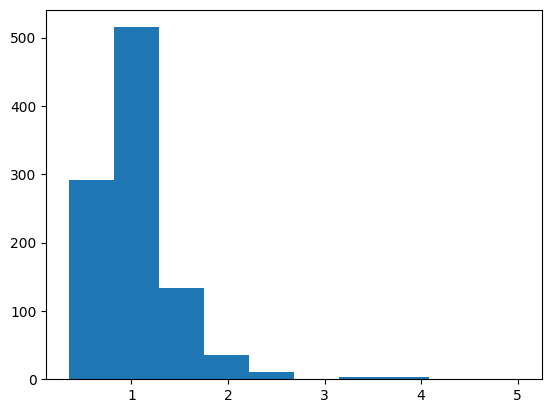

In [64]:
plt.hist(pd.DataFrame(im_features).sum())

#### Réduction de dimension:
##### PCA:

In [67]:
print("Dimensions of the dataset before reduction with a PCA : ", im_features.shape)
pca = PCA(n_components=0.99)
X_pca= pca.fit_transform(im_features)
print("Dimensions of the dataset after reduction with a PCA : ", X_pca.shape)

Dimensions of the dataset before reduction with a PCA :  (1050, 995)
Dimensions of the dataset after reduction with a PCA :  (1050, 574)


In [68]:
dataframe_text = pd.DataFrame()
dataframe_text['VAR1'] = X_pca[:, 0]
dataframe_text['VAR2'] = X_pca[:, 1]
#dataframe_text['CATEGORIE'] = df_image['sub_cat 0']

#### Projection_PCA en 2D:
* visualisation:

In [69]:
proj = PCA(n_components=2)

In [70]:
X_tmp = proj.fit_transform(dataframe_text)
dataframe_image = pd.DataFrame()
dataframe_image['VAR1'] = X_tmp[:, 0]
dataframe_image['VAR2'] = X_tmp[:, 1]
dataframe_image['CATEGORIE'] = df_image['sub_cat 0']

c:\Python38\lib\site-packages\seaborn\relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


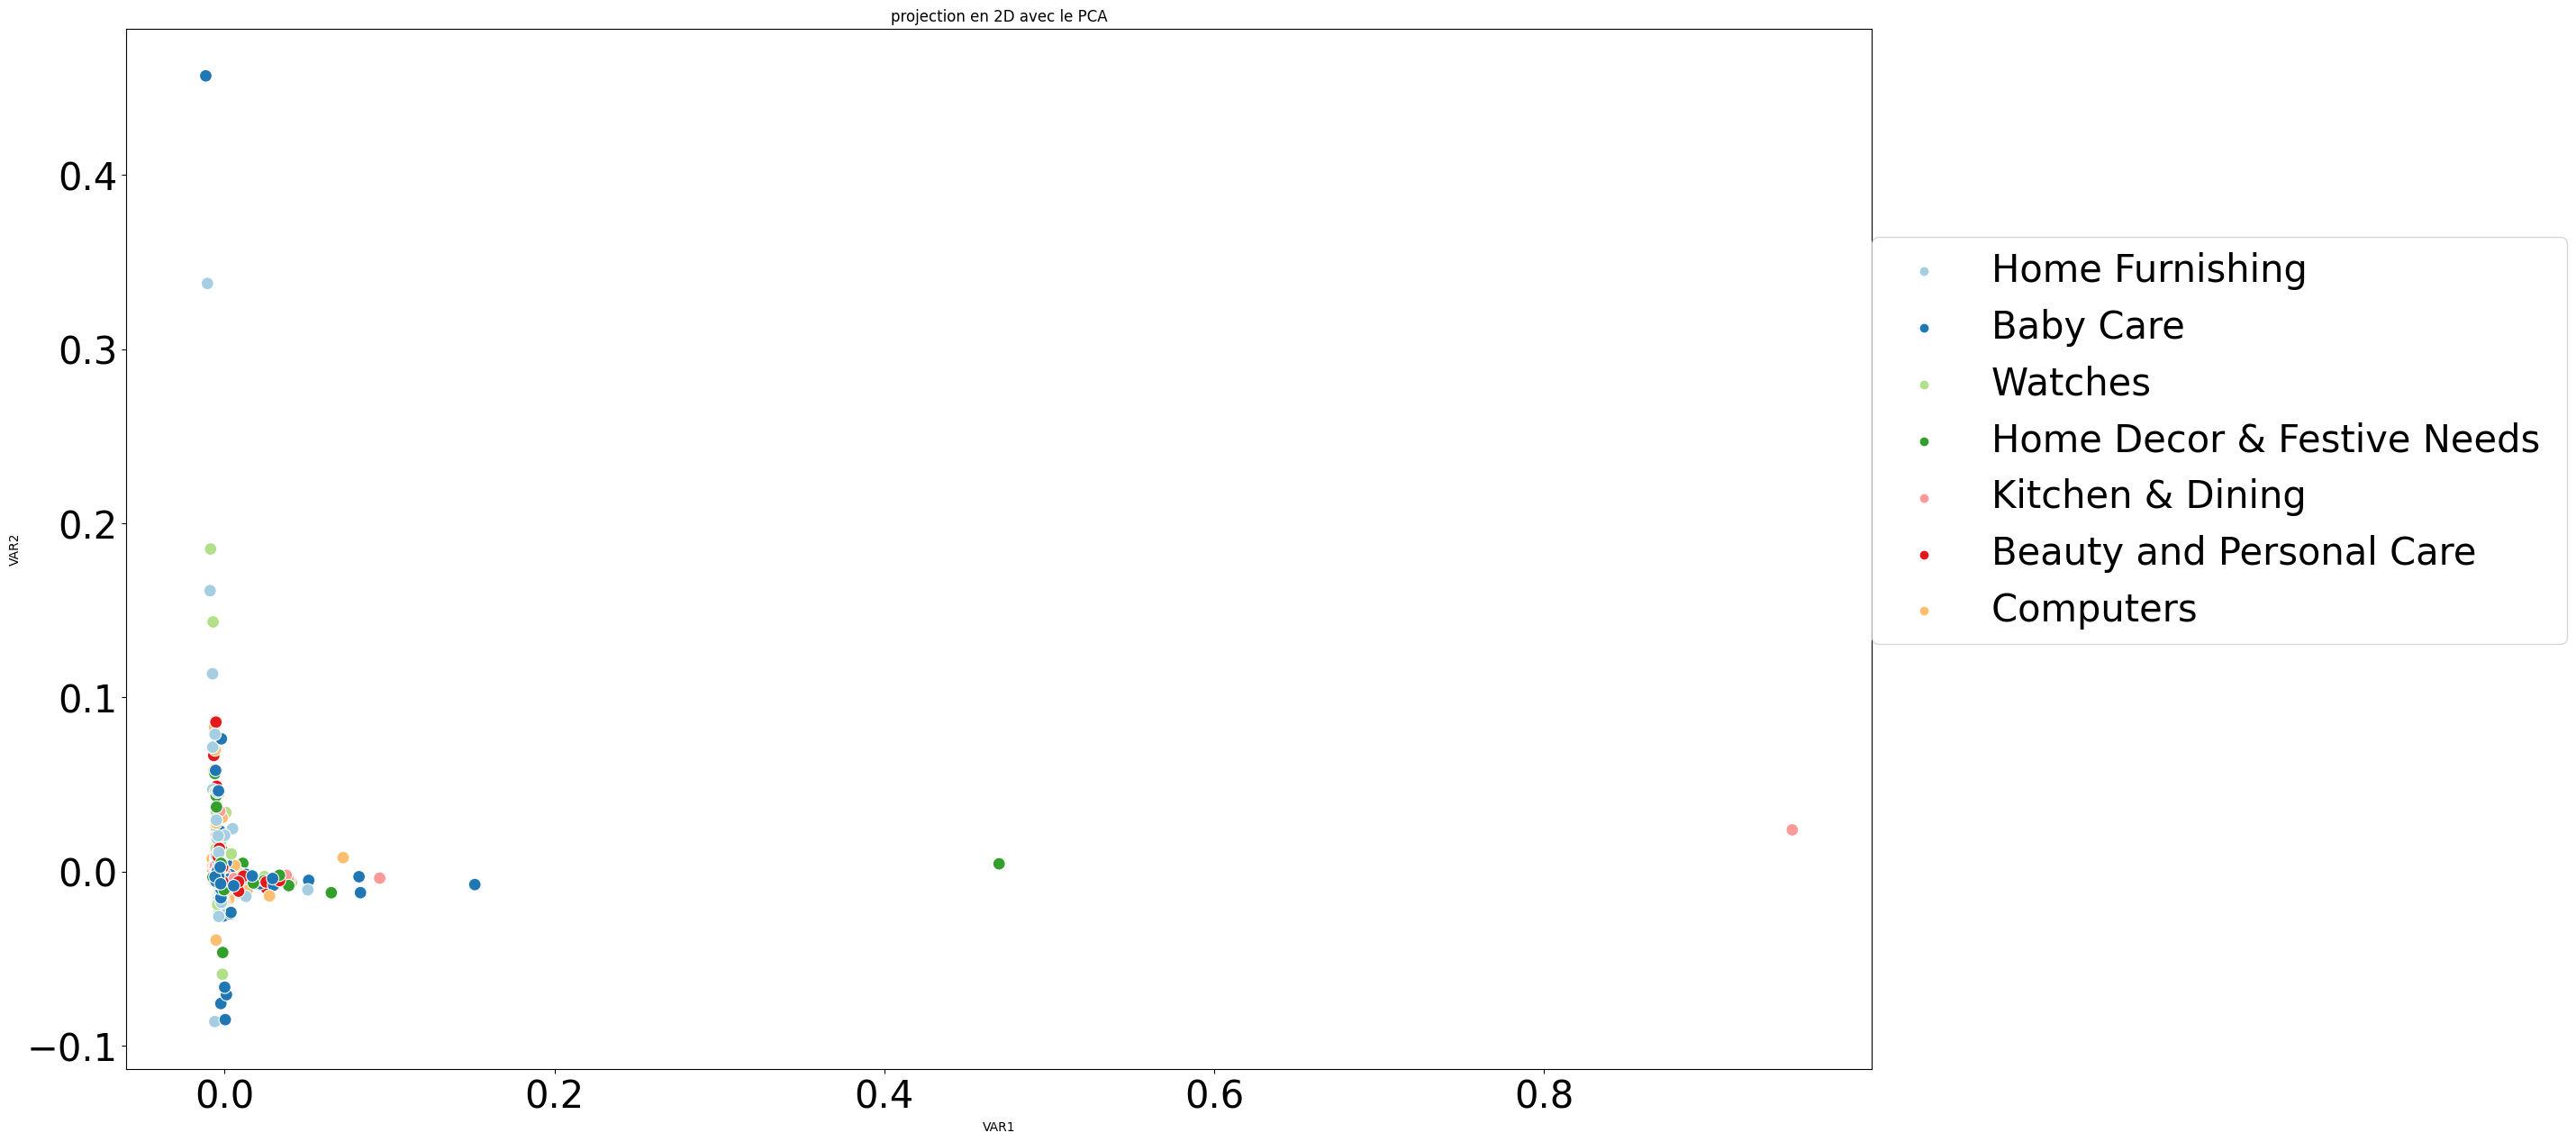

In [71]:
plt.figure(figsize=[25, 15])

sns.set_palette('Paired')
sns.scatterplot(x='VAR1', y='VAR2', data=dataframe_image, hue='CATEGORIE',
                s=100, alpha=1, cmap=ListedColormap(sns.color_palette('tab10')))

plt.legend(bbox_to_anchor=(1, 0.8), loc=2, borderaxespad=0., fontsize=30)
plt.title("projection en 2D avec le PCA")
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid(False)
plt.show()


* On vois que tout les produits sont condencés dans un seul endroit.

#### Réduction de dimension avec TSNE:

In [72]:
tsne = TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(X_pca)  
dataframe_tsne = pd.DataFrame()
dataframe_tsne['VAR1'] = X_tsne[:, 0]
dataframe_tsne['VAR2'] = X_tsne[:, 1]
dataframe_tsne['CATEGORIE'] = df_image['sub_cat 0']                 

##### Tsne , visualisation de vrai catégories:

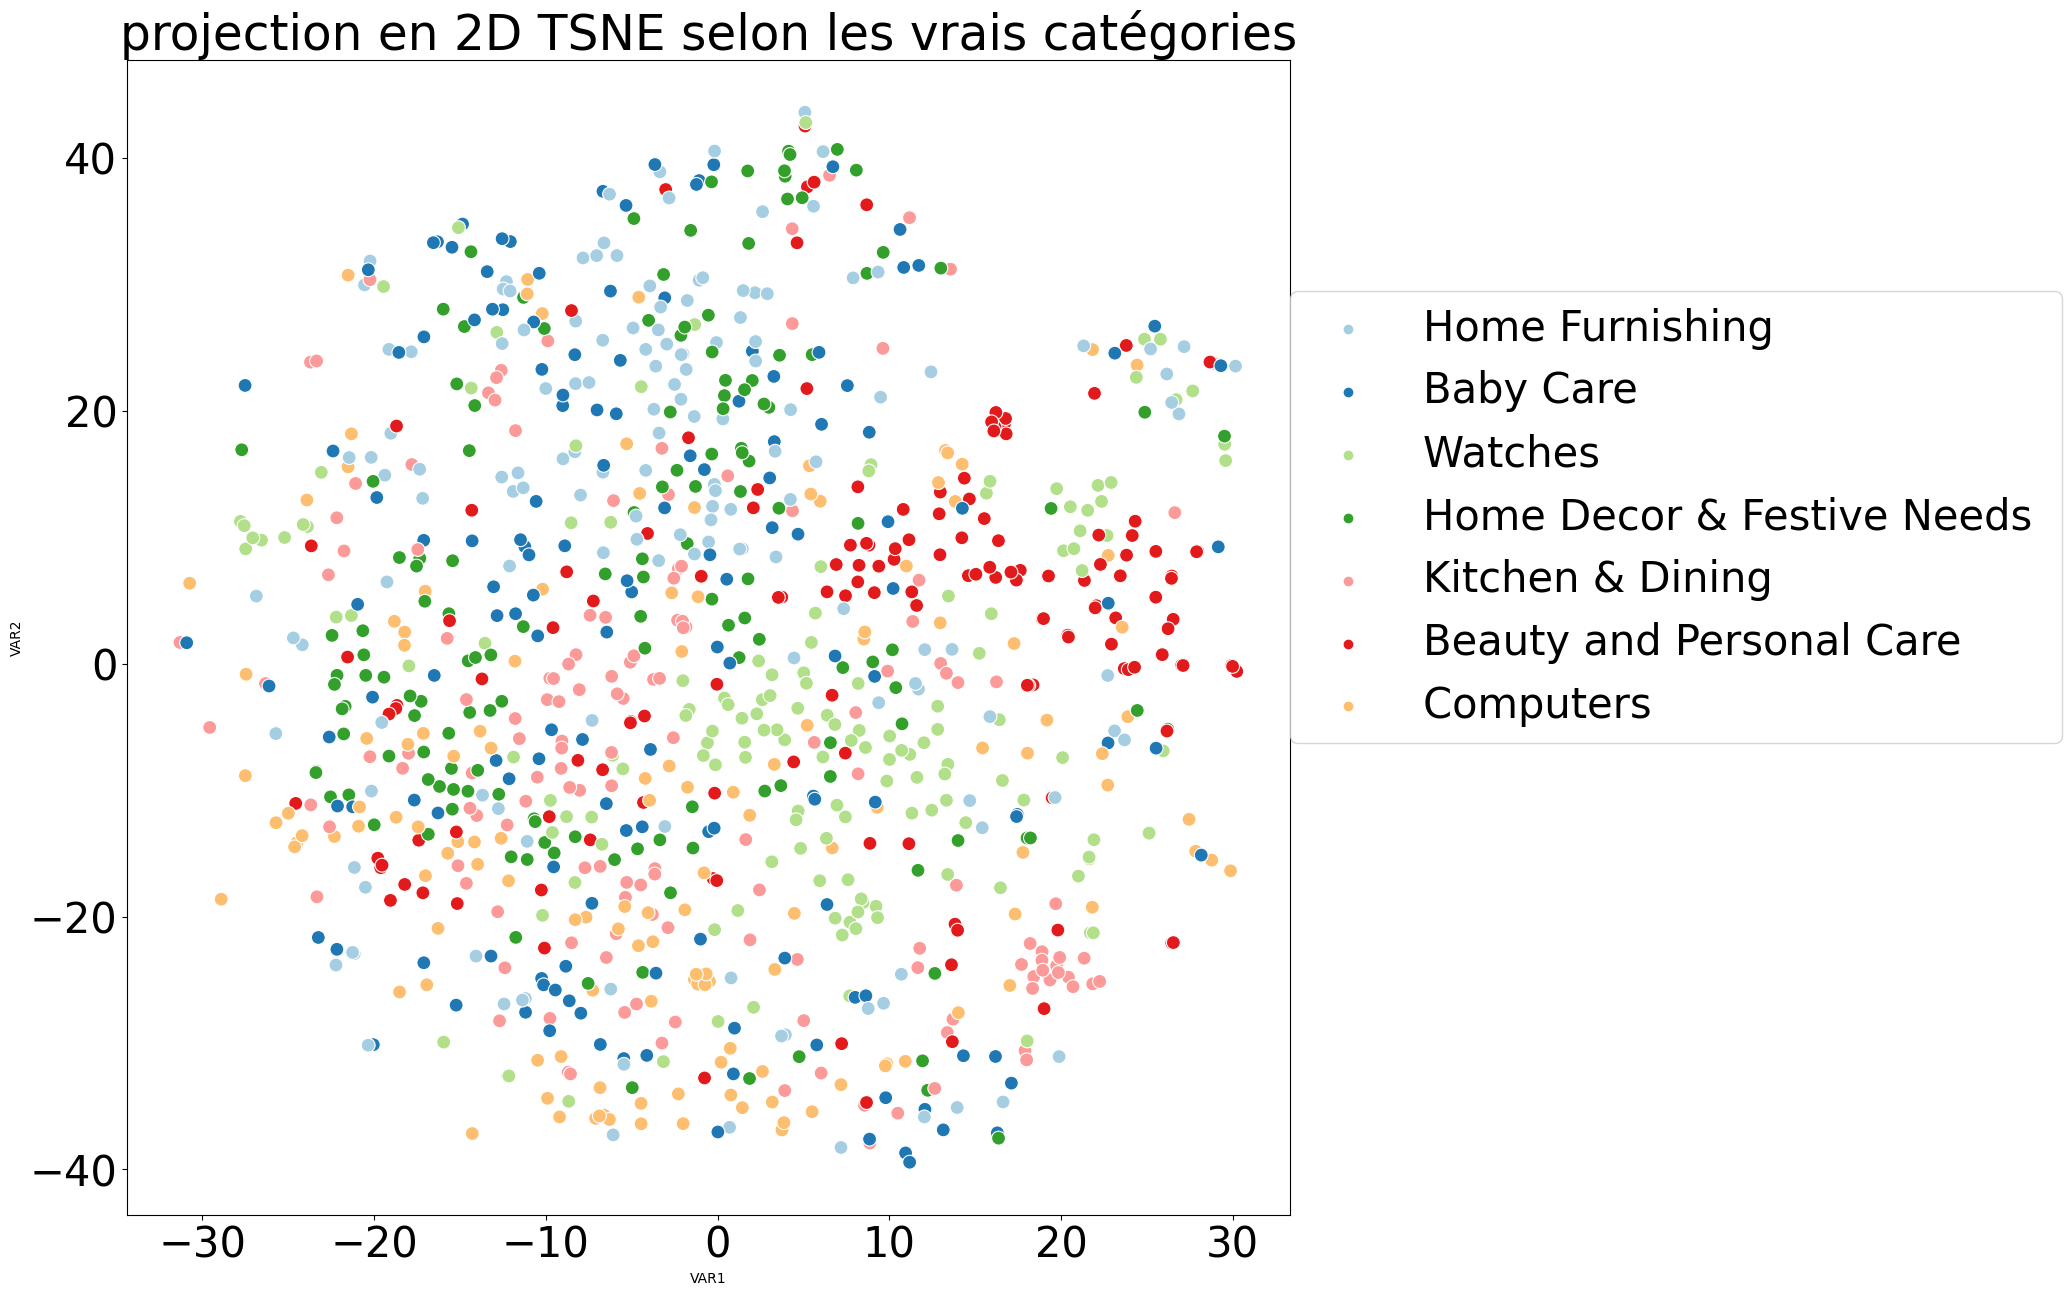

In [73]:
plt.figure(figsize=[15, 15])

sns.set_palette('Paired')
sns.scatterplot(x='VAR1', y='VAR2', data=dataframe_tsne, hue='CATEGORIE',
                s=100, alpha=1)

plt.legend(bbox_to_anchor=(1, 0.8), loc=2, borderaxespad=0., fontsize=30)
plt.title("projection en 2D TSNE selon les vrais catégories", fontsize = 35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid(False)
plt.show()

* Avec les données tsne et sift , on vois que les catégories sont mélangées, 

#### Clustering:

##### KMEANS:

In [74]:
cols = ['VAR1', 'VAR2']
# Instanciation du modèle KMeans avec les meilleurs paramètres
kmeans_tsne_sift = KMeans(n_clusters=7, init='k-means++',
                          n_init=100, max_iter=300,
                          random_state=24) \
    .fit(dataframe_tsne[cols])
# Ajout de l'assignation du cluster au dataframe
dataframe_tsne['Clusters'] = kmeans_tsne_sift.labels_
kmeans_tsne_sift_labels = kmeans_tsne_sift.labels_



In [75]:
dataframe_tsne

,VAR1,VAR2,CATEGORIE,Clusters
0,-9.000571,16.212429,Home Furnishing,2
1,2.025678,24.734417,Baby Care,2
2,3.182507,10.768072,Baby Care,3
3,-1.568650,34.182476,Home Furnishing,2
4,2.213300,25.493696,Home Furnishing,2
...,...,...,...,...
1045,-10.472509,2.207713,Baby Care,6
1046,28.166866,-15.131618,Baby Care,5
1047,-16.498941,-0.920124,Baby Care,6
1048,11.186038,-39.429428,Baby Care,1


In [76]:
metrique = calcul_metriques_clusters(dataframe_tsne, "TSNE_SIFT")
metrique

,Type_donnees,ARI,Homogeneite,Completude,V-measure
0,TSNE_SIFT,0.062361,0.099553,0.100521,0.100034


* Le score ARI est trés faible.

In [ ]:
affiche_repartition_par_clusters(kmeans_tsne_sift_labels)

In [ ]:
# Les catégories par clusters
dataframe_tsne.groupby('Clusters')['CATEGORIE'].value_counts().to_frame()

CATEGORIE
Clusters CATEGORIE                             
0        Home Decor & Festive Needs          54
         Kitchen & Dining                    42
         Computers                           35
         Baby Care                           27
         Watches                             24
         Beauty and Personal Care            23
         Home Furnishing                     14
1        Beauty and Personal Care            51
         Watches                             31
         Computers                            8
         Home Furnishing                      7
         Baby Care                            6
         Kitchen & Dining                     6
         Home Decor & Festive Needs           4
2        Kitchen & Dining                    37
         Computers                           26
         Baby Care                           18
         Home Furnishing                     14
         Beauty and Personal Care            12
         Watches                             10
         Home Decor & Festive Needs           8
3        Computers                           39
         Kitchen & Dining                    28
         Baby Care                           19
         Watches                             19
         Home Furnishing                     14
         Home Decor & Festive Needs          13
         Beauty and Personal Care             8
4        Home Furnishing                     52
         Baby Care                           43
         Home Decor & Festive Needs          29
         Kitchen & Dining                    13
         Computers                           11
         Watches                             10
         Beauty and Personal Care             6
5        Watches                             44
         Beauty and Personal Care            35
         Computers                           22
         Baby Care                           16
         Kitchen & Dining                    11
         Home Decor & Festive Needs          10
         Home Furnishing                      6
6        Home Furnishing                     43
         Home Decor & Festive Needs          32
         Baby Care                           21
         Beauty and Personal Care            15
         Kitchen & Dining                    13
         Watches                             12
         Computers                            9

#### Visualisation des clusters:

In [ ]:
def visualisation_clusters(proj, clusters_labels, titre):
    plt.figure(figsize=[25, 15])
    sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=clusters_labels, s=100, alpha=1, palette='Set1')
    plt.title(titre, fontsize=25)
    plt.legend(bbox_to_anchor=(1.05, 1), loc= 1,  fontsize=25)
    plt.show()

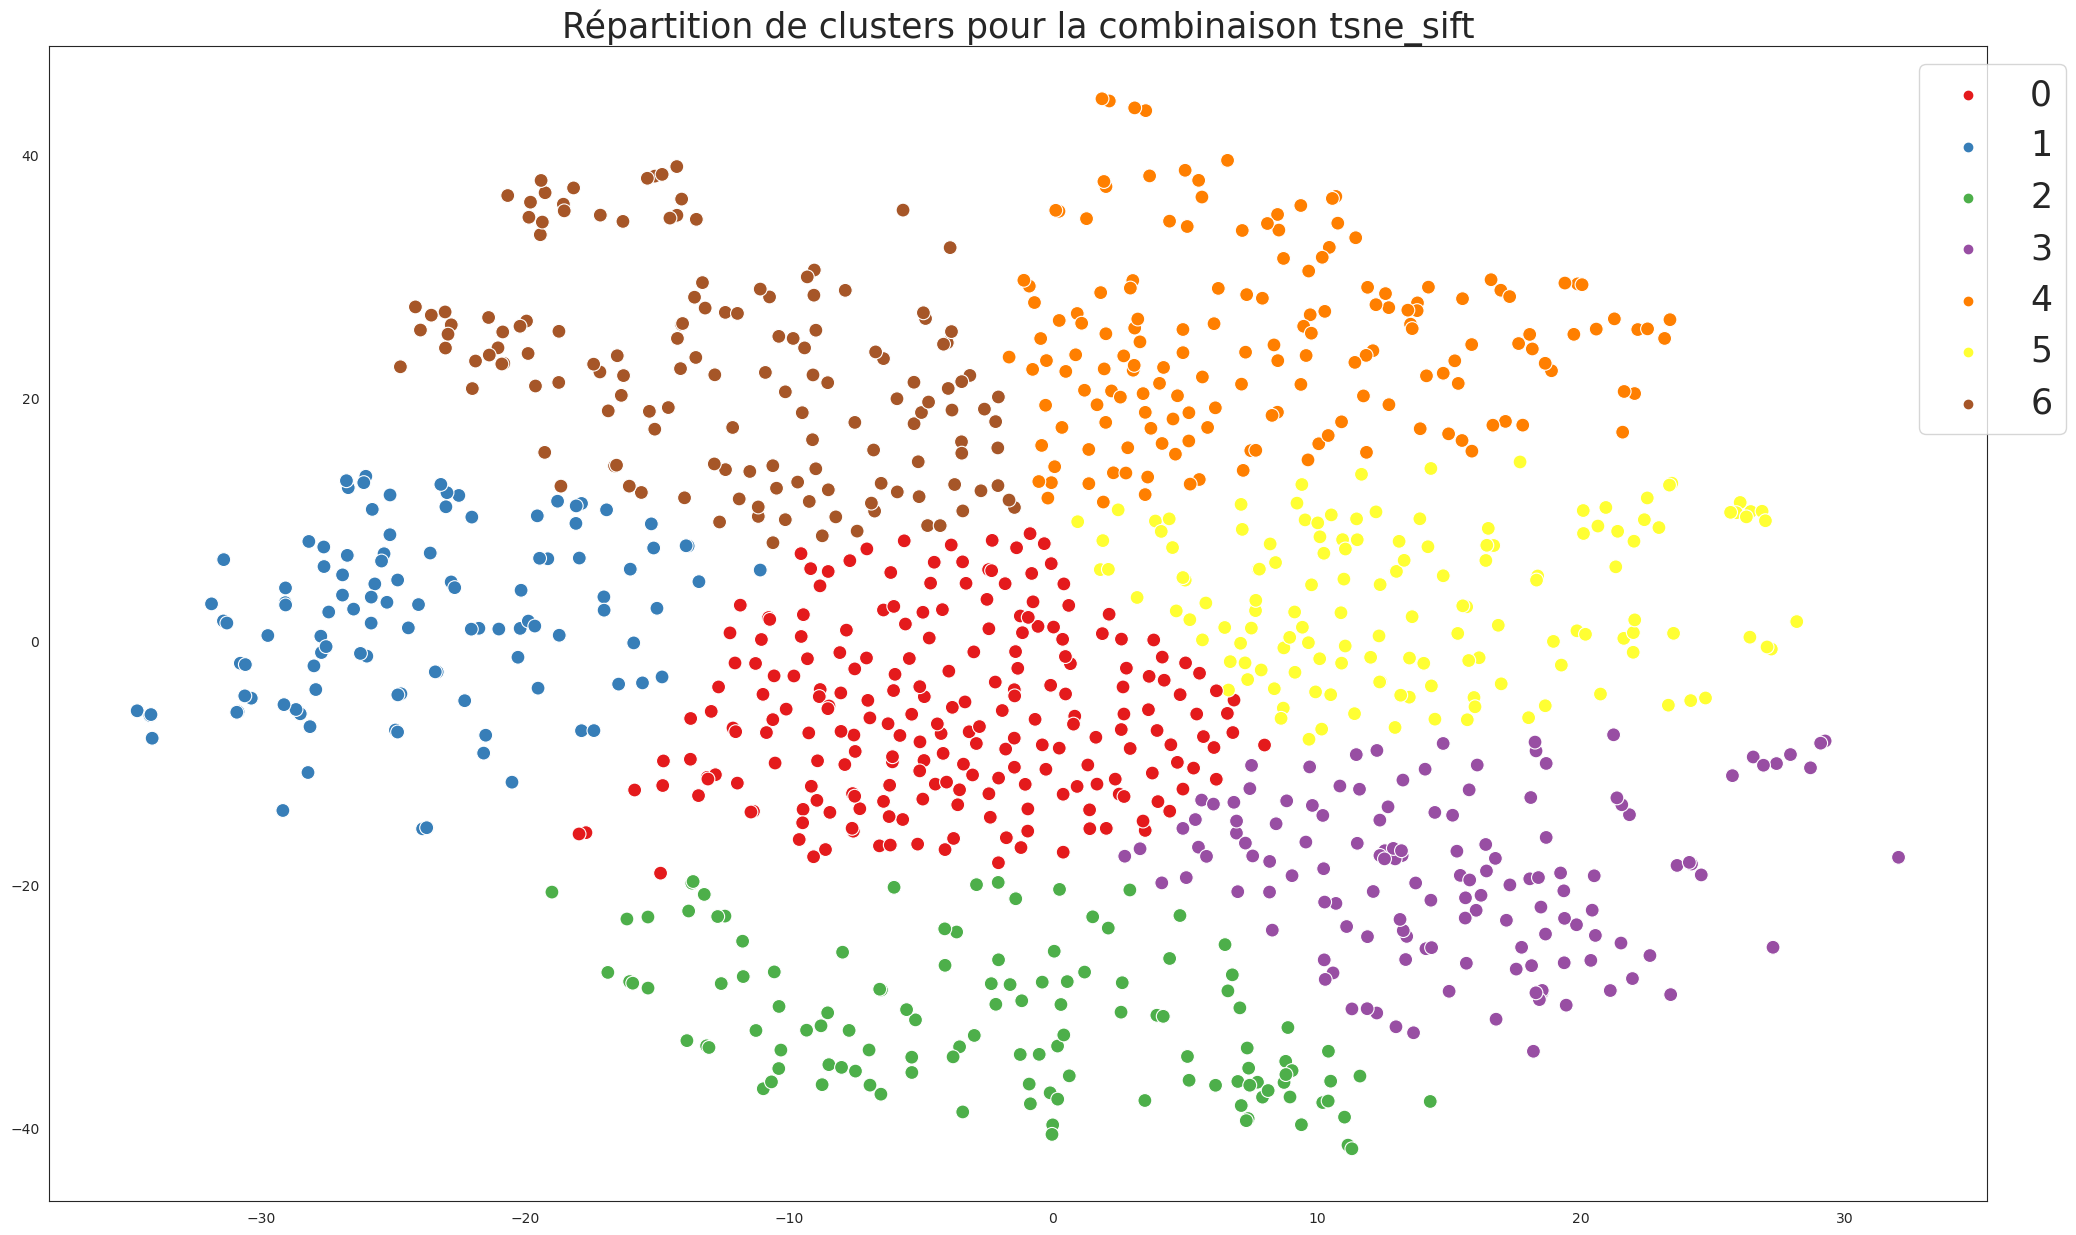

In [ ]:
visualisation_clusters(X_tsne,kmeans_tsne_sift_labels,'Répartition de clusters pour la combinaison tsne_sift')

#### Bilan d'analyse:
*********
 Avec la combinaison sift et tsne , on arrive bien a trouver les catégories mais avec beaucoup de mélanges.
 * le score ARI est trés faible. est à 0.05
 **************

* Encodage des données (categories)

In [ ]:
le = preprocessing.LabelEncoder()
dataframe_tsne["label"] = le.fit_transform(dataframe_tsne['CATEGORIE'])
y = le.fit_transform(dataframe_tsne['CATEGORIE'])
y_true = dataframe_tsne["label"]
y_pred = dataframe_tsne['Clusters']

In [ ]:
dataframe_tsne

,VAR1,VAR2,CATEGORIE,Clusters,label
0,22.026438,20.374508,Home Furnishing,4,4
1,-4.006339,24.553930,Baby Care,6,0
2,-21.564878,-9.188783,Baby Care,1,0
3,-10.385725,25.076330,Home Furnishing,6,4
4,-9.410548,24.126665,Home Furnishing,6,4
...,...,...,...,...,...
1045,-4.688380,0.273631,Baby Care,0,0
1046,27.042599,-0.462102,Baby Care,5,0
1047,-9.302029,-1.431449,Baby Care,0,0
1048,-5.547258,-30.280685,Baby Care,2,0


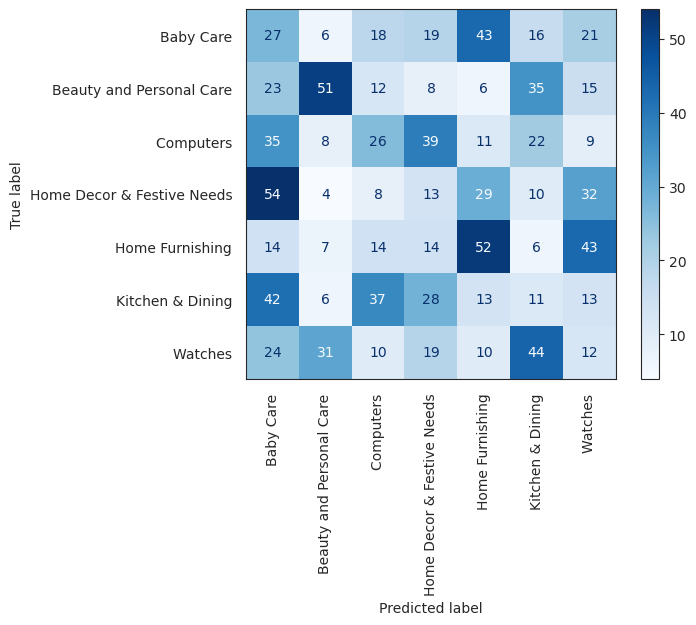

In [ ]:
fig, ax = plt.subplots()
confmatrix = metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                                                            display_labels=[le.inverse_transform([i])[0] for i in range(7)],
                                                        xticks_rotation='vertical', cmap='Blues', ax=ax)


In [ ]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.12      0.18      0.15       150
           1       0.45      0.34      0.39       150
           2       0.21      0.17      0.19       150
           3       0.09      0.09      0.09       150
           4       0.32      0.35      0.33       150
           5       0.08      0.07      0.07       150
           6       0.08      0.08      0.08       150

    accuracy                           0.18      1050
   macro avg       0.19      0.18      0.19      1050
weighted avg       0.19      0.18      0.19      1050



********

## La classification Supervisée:

### 6.1 KNeighborsClassifier

### donnée apres la reductions de dimenssionalité:

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_validate
seed = 33
testsize = 0.2
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = seed)

X_train, X_test, y_train, y_test = train_test_split(dataframe_text, y, 
                                                    test_size=testsize, random_state=seed, shuffle=True, stratify=y)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)
y_train_clf = kn.predict(X_train)
y_test_clf = kn.predict(X_test)
train_score = metrics.accuracy_score(y_train, y_train_clf)
test_score = metrics.accuracy_score(y_test, y_test_clf)
print(train_score, test_score)

0.48095238095238096 0.23333333333333334


In [ ]:
my_data = dataframe_tsne[['VAR1','VAR2']]

*Classification avec les données tsne :

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV, cross_validate
seed = 33
testsize = 0.2
#cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = seed)

X_train, X_test, y_train, y_test = train_test_split(my_data, dataframe_tsne['label'], 
                                                    test_size=testsize, random_state=seed, shuffle=True, stratify=dataframe_tsne['label'])

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)
y_train_clf = kn.predict(X_train)
y_test_clf = kn.predict(X_test)
train_score = metrics.accuracy_score(y_train, y_train_clf)
test_score = metrics.accuracy_score(y_test, y_test_clf)
print(train_score, test_score)

0.5761904761904761 0.43333333333333335


* Mettre les metrics dans un tableau de dataframe.

In [ ]:
dct = {'accuracy_train' :train_score,
        'accuracy_test': test_score,
        'Modeles': 'KNeighborsClassifier_sift_tsne'}
clf_suppervisée = pd.DataFrame([dct])
clf_suppervisée

,accuracy_train,accuracy_test,Modeles
0,0.57619,0.433333,KNeighborsClassifier_sift_tsne


<Figure size 400x500 with 0 Axes>

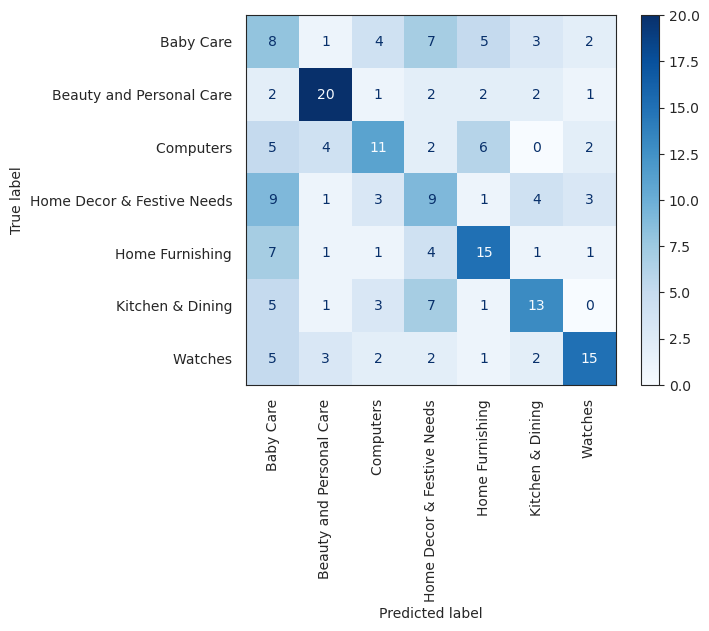

In [ ]:
plt.figure(figsize=(4,5))
fig, ax = plt.subplots()
confmatrix = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_clf,
                                                             display_labels=[le.inverse_transform([i])[0] for i in range(7)],
                                                             xticks_rotation='vertical', cmap='Blues', ax=ax)

In [ ]:
report = classification_report(y_test, y_test_clf)
print(report)

              precision    recall  f1-score   support

           0       0.20      0.27      0.23        30
           1       0.65      0.67      0.66        30
           2       0.44      0.37      0.40        30
           3       0.27      0.30      0.29        30
           4       0.48      0.50      0.49        30
           5       0.52      0.43      0.47        30
           6       0.62      0.50      0.56        30

    accuracy                           0.43       210
   macro avg       0.45      0.43      0.44       210
weighted avg       0.45      0.43      0.44       210



### Randomforest classifier:

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_train_clf = rfc.predict(X_train)
y_test_clf = rfc.predict(X_test)
train_score = metrics.accuracy_score(y_train, y_train_clf)
test_score = metrics.accuracy_score(y_test, y_test_clf)
print(train_score, test_score)

1.0 0.47619047619047616


* Mettre les données dans dataframe

In [ ]:
dct = {'accuracy_train' :train_score,
        'accuracy_test': test_score,
        'Modeles': 'Randomforest_clf_sift_tsne'}
clf_suppervisée =clf_suppervisée.append([dct])
clf_suppervisée

/tmp/ipykernel_33561/3760344873.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clf_suppervisée =clf_suppervisée.append([dct])


,accuracy_train,accuracy_test,Modeles
0,0.57619,0.433333,KNeighborsClassifier_sift_tsne
0,1.00000,0.476190,Randomforest_clf_sift_tsne


<Figure size 400x500 with 0 Axes>

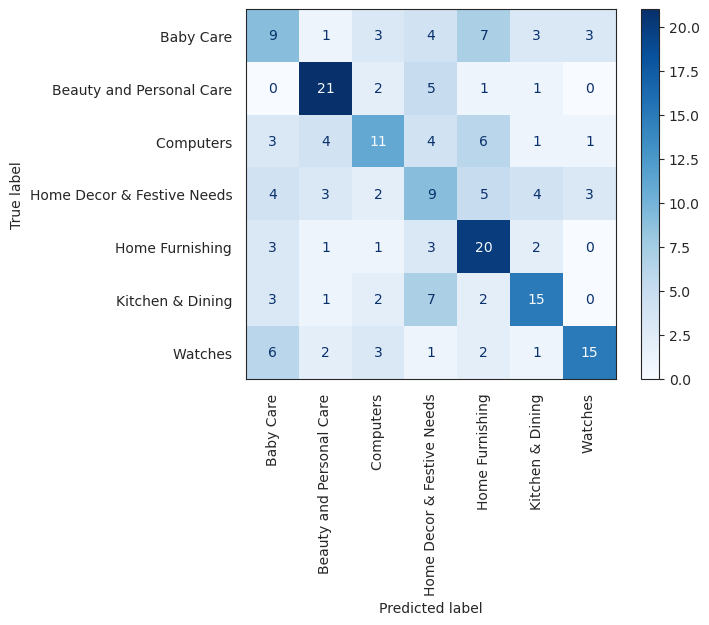

In [ ]:
plt.figure(figsize=(4,5))
fig, ax = plt.subplots()
confmatrix = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_clf,
                                                             display_labels=[le.inverse_transform([i])[0] for i in range(7)],
                                                             xticks_rotation='vertical', cmap='Blues', ax=ax)

In [ ]:
report = classification_report(y_test, y_test_clf)
print(report)

              precision    recall  f1-score   support

           0       0.32      0.30      0.31        30
           1       0.64      0.70      0.67        30
           2       0.46      0.37      0.41        30
           3       0.27      0.30      0.29        30
           4       0.47      0.67      0.55        30
           5       0.56      0.50      0.53        30
           6       0.68      0.50      0.58        30

    accuracy                           0.48       210
   macro avg       0.48      0.48      0.47       210
weighted avg       0.48      0.48      0.47       210



### svc

In [ ]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)
y_train_clf = clf.predict(X_train)
y_test_clf = clf.predict(X_test)
train_score = metrics.accuracy_score(y_train, y_train_clf)
test_score = metrics.accuracy_score(y_test, y_test_clf)
print(train_score, test_score)

0.375 0.35714285714285715


In [ ]:
dct = {'accuracy_train' :train_score,
        'accuracy_test': test_score,
        'Modeles': 'SVC_sift_tsne'}
clf_suppervisée =clf_suppervisée.append([dct])
clf_suppervisée

/tmp/ipykernel_33561/2213622506.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  clf_suppervisée =clf_suppervisée.append([dct])


,accuracy_train,accuracy_test,Modeles
0,0.57619,0.433333,KNeighborsClassifier_sift_tsne
0,1.00000,0.476190,Randomforest_clf_sift_tsne
0,0.37500,0.357143,SVC_sift_tsne


<Figure size 400x500 with 0 Axes>

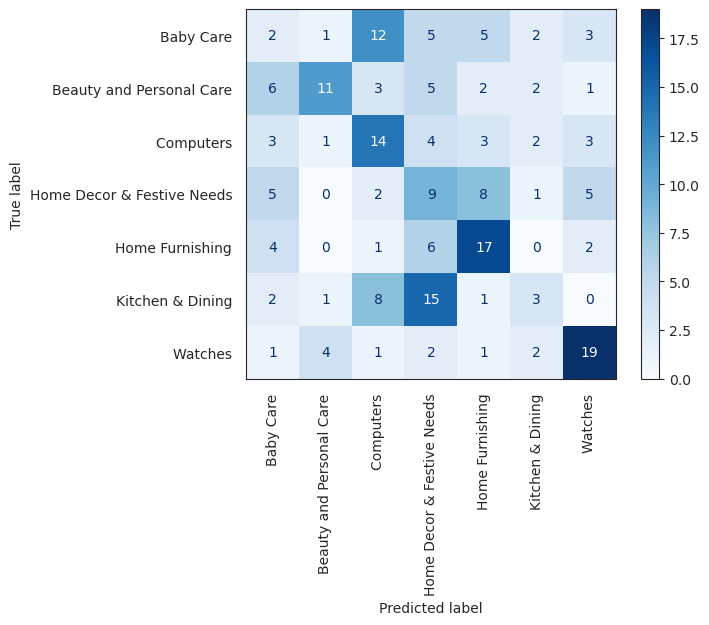

In [ ]:
plt.figure(figsize=(4,5))
fig, ax = plt.subplots()
confmatrix = metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_test_clf,
                                                             display_labels=[le.inverse_transform([i])[0] for i in range(7)],
                                                             xticks_rotation='vertical', cmap='Blues', ax=ax)

In [ ]:
report = classification_report(y_test, y_test_clf)
print(report)

              precision    recall  f1-score   support

           0       0.09      0.07      0.08        30
           1       0.61      0.37      0.46        30
           2       0.34      0.47      0.39        30
           3       0.20      0.30      0.24        30
           4       0.46      0.57      0.51        30
           5       0.25      0.10      0.14        30
           6       0.58      0.63      0.60        30

    accuracy                           0.36       210
   macro avg       0.36      0.36      0.35       210
weighted avg       0.36      0.36      0.35       210



In [ ]:
clf_suppervisée.to_csv('metriques_sift_clf_supervisée.csv')

In [ ]:
dataframe_metriques = metrique.to_csv('metrics_clf_non_supervisée.csv')